# Trust the Process: An Analysis of Tanking in the Modern NBA

Kwabena Aduse-Poku

## Motivation

Supporting a mediocre NBA team is hard. After great players age out or move away, your favorite team might be left in an uncomfortable middle ground. There are two ways to escape mediocrity: rapidly improve, or purposefully get worse in an attempt to receive a high pick in the draft lottery. This process of deliberately worsening a team in order to drop through the rankings is commonly called "tanking". Can we use data to describe what a tanking team looks like, and can we determine if tanking is truly a successful strategy in the modern NBA? Let's explore.

## Finding Tanking Teams

The analysis that we can do is going to be determined by the data we have available to us. Thankfully, there are great resources that we can use to pull the data that we need to do our analysis. We will be pulling primarily from [basketball reference](https://www.basketball-reference.com) through this [handy scraping API](https://github.com/vishaalagartha/basketball_reference_scraper). Below we import some necessary libraries: `requests` and `BeautifulSoup` for web scraping (necessary for future analysis), basketball reference functions to get information about teams and box scores, `pandas` and `numpy` for data manipulation, and `matplotlib` and `seaborn` for data visualization.

In [188]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.seasons import get_standings
from basketball_reference_scraper.box_scores import get_box_scores
import matplotlib.pyplot as plt
import seaborn as sns

Next, we need to construct our datasets. In order to find tanking teams to analyze, we need to look at a variety of team statistics. These include win rates over multiple seasons, expected wins, and player trades. Let's use basketball reference to get win rate tables over the last 10 years.

The information from our basketball reference scraper is pulled into [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We can use these dataframes to make plots and do further analysis, but we need to ensure that each one has the same format. This requires a little cleaning with the python script below:

In [189]:
# Construct 10 dataframes, one for each year. then append with column for year
# First get dataframes and put them in a list

dfs = []
datelem = '-06-01'
divisions = ['Atlantic Division', 'Central Division', 'Southeast Division', 'Northwest Division', 'Pacific Division', 'Southwest Division']
for year in range (2002, 2022):
    datestr = str(year) + datelem
    if year == 2020:
        datestr = '2020-10-01'
    
    dfpair = get_standings(datestr)
    # Clean the resulting dataframes (drop conference rows)
    for k, conf in dfpair.items():
        dfpair[k] = conf[(conf['TEAM'] != 'Atlantic Division') \
                        & (conf['TEAM'] != 'Central Division') \
                        & (conf['TEAM'] != 'Southeast Division') \
                        & (conf['TEAM'] != 'Northwest Division') \
                        & (conf['TEAM'] != 'Pacific Division') \
                        & (conf['TEAM'] != 'Southwest Division') \
                        & (conf['TEAM'] != 'Midwest Division')]
        dfpair[k].insert(0, 'SEASON', year)

    dfs.append(dfpair)

Once we have confirmed that each dataframe is added to our list, we can concatenate them together.

In [190]:
# For the purposes of this analysis, we will not make a distinction between Eastern and Western Conference
# Start by turning the list of dictionaries into a list of dataframes
season_list = []
for pair in dfs:
    season_list.append(pair['EASTERN_CONF'])
    season_list.append(pair['WESTERN_CONF'])

In [191]:
# Concatenate dataframe:
seasons = pd.concat(season_list)
seasons

,SEASON,TEAM,W,L,W/L%,GB,PW,PL,PS/G,PA/G
1,2002,New Jersey Nets*,52,30,.634,—,53,29,96.2,92.0
2,2002,Boston Celtics*,49,33,.598,3.0,48,34,96.4,94.1
3,2002,Orlando Magic*,44,38,.537,8.0,46,36,100.5,98.9
4,2002,Philadelphia 76ers*,43,39,.524,9.0,46,36,91.0,89.4
5,2002,Washington Wizards,37,45,.451,15.0,37,45,92.8,94.2
...,...,...,...,...,...,...,...,...,...,...
10,2021,New Orleans Pelicans,31,41,0.431,21.0,35,37,114.6,114.9
11,2021,Sacramento Kings,31,41,0.431,21.0,28,44,113.7,117.4
12,2021,Minnesota Timberwolves,23,49,0.319,29.0,24,48,112.1,117.7
13,2021,Oklahoma City Thunder,22,50,0.306,30.0,15,57,105.0,115.6


Basketball reference includes a '*' to denote teams that made the playoffs in that year. We will not be using that information for this analysis, so we will remove that signifier from the `TEAM` column.

In [192]:
# Remove the '*' from team names where they appear
seasons['TEAM'] = seasons['TEAM'].str.replace('*','', regex=False)
seasons = seasons.reset_index(drop=True)
seasons

,SEASON,TEAM,W,L,W/L%,GB,PW,PL,PS/G,PA/G
0,2002,New Jersey Nets,52,30,.634,—,53,29,96.2,92.0
1,2002,Boston Celtics,49,33,.598,3.0,48,34,96.4,94.1
2,2002,Orlando Magic,44,38,.537,8.0,46,36,100.5,98.9
3,2002,Philadelphia 76ers,43,39,.524,9.0,46,36,91.0,89.4
4,2002,Washington Wizards,37,45,.451,15.0,37,45,92.8,94.2
...,...,...,...,...,...,...,...,...,...,...
592,2021,New Orleans Pelicans,31,41,0.431,21.0,35,37,114.6,114.9
593,2021,Sacramento Kings,31,41,0.431,21.0,28,44,113.7,117.4
594,2021,Minnesota Timberwolves,23,49,0.319,29.0,24,48,112.1,117.7
595,2021,Oklahoma City Thunder,22,50,0.306,30.0,15,57,105.0,115.6


Now that we have 20 years of season data, we can create a plot of win rate for each team over time. Let's make a stacked line plot to show the change in win rate across all the teams for this period of time. We can start by using [seaborn's lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to make an overall graph of all teams. 

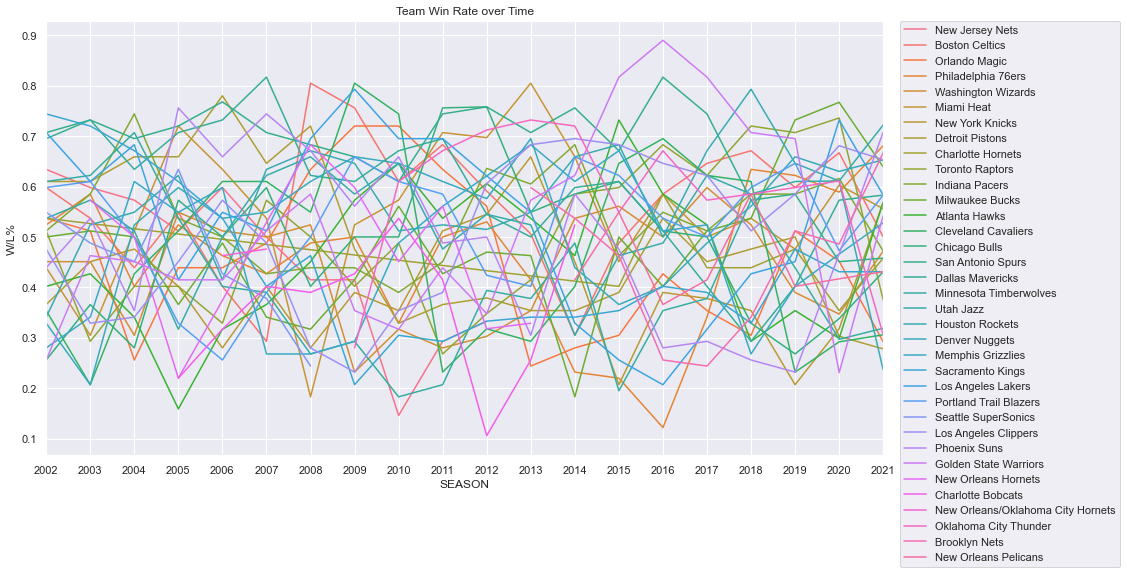

In [193]:
# Make plot using Seaborn

seasons['W/L%'] = seasons['W/L%'].astype('float')
boston_wr = seasons.query('TEAM == "Boston Celtics"')

sns.set(rc = {'figure.figsize':(15,8)})

fig, ax = plt.subplots()
ax.set_xlim(2002,2021)
ax.set_xticks(range(2002,2022))
sns.lineplot(data=seasons, x='SEASON', y='W/L%', hue='TEAM').set(title='Team Win Rate over Time')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

This is quite messy and almost impossible to decipher. Rather than looking at all of the teams on one plot, let's instead make separate plots for each individual team. We can do this using [seaborn's facet grid object](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html). We can then plot lineplots for each team across the entire grid of plots.

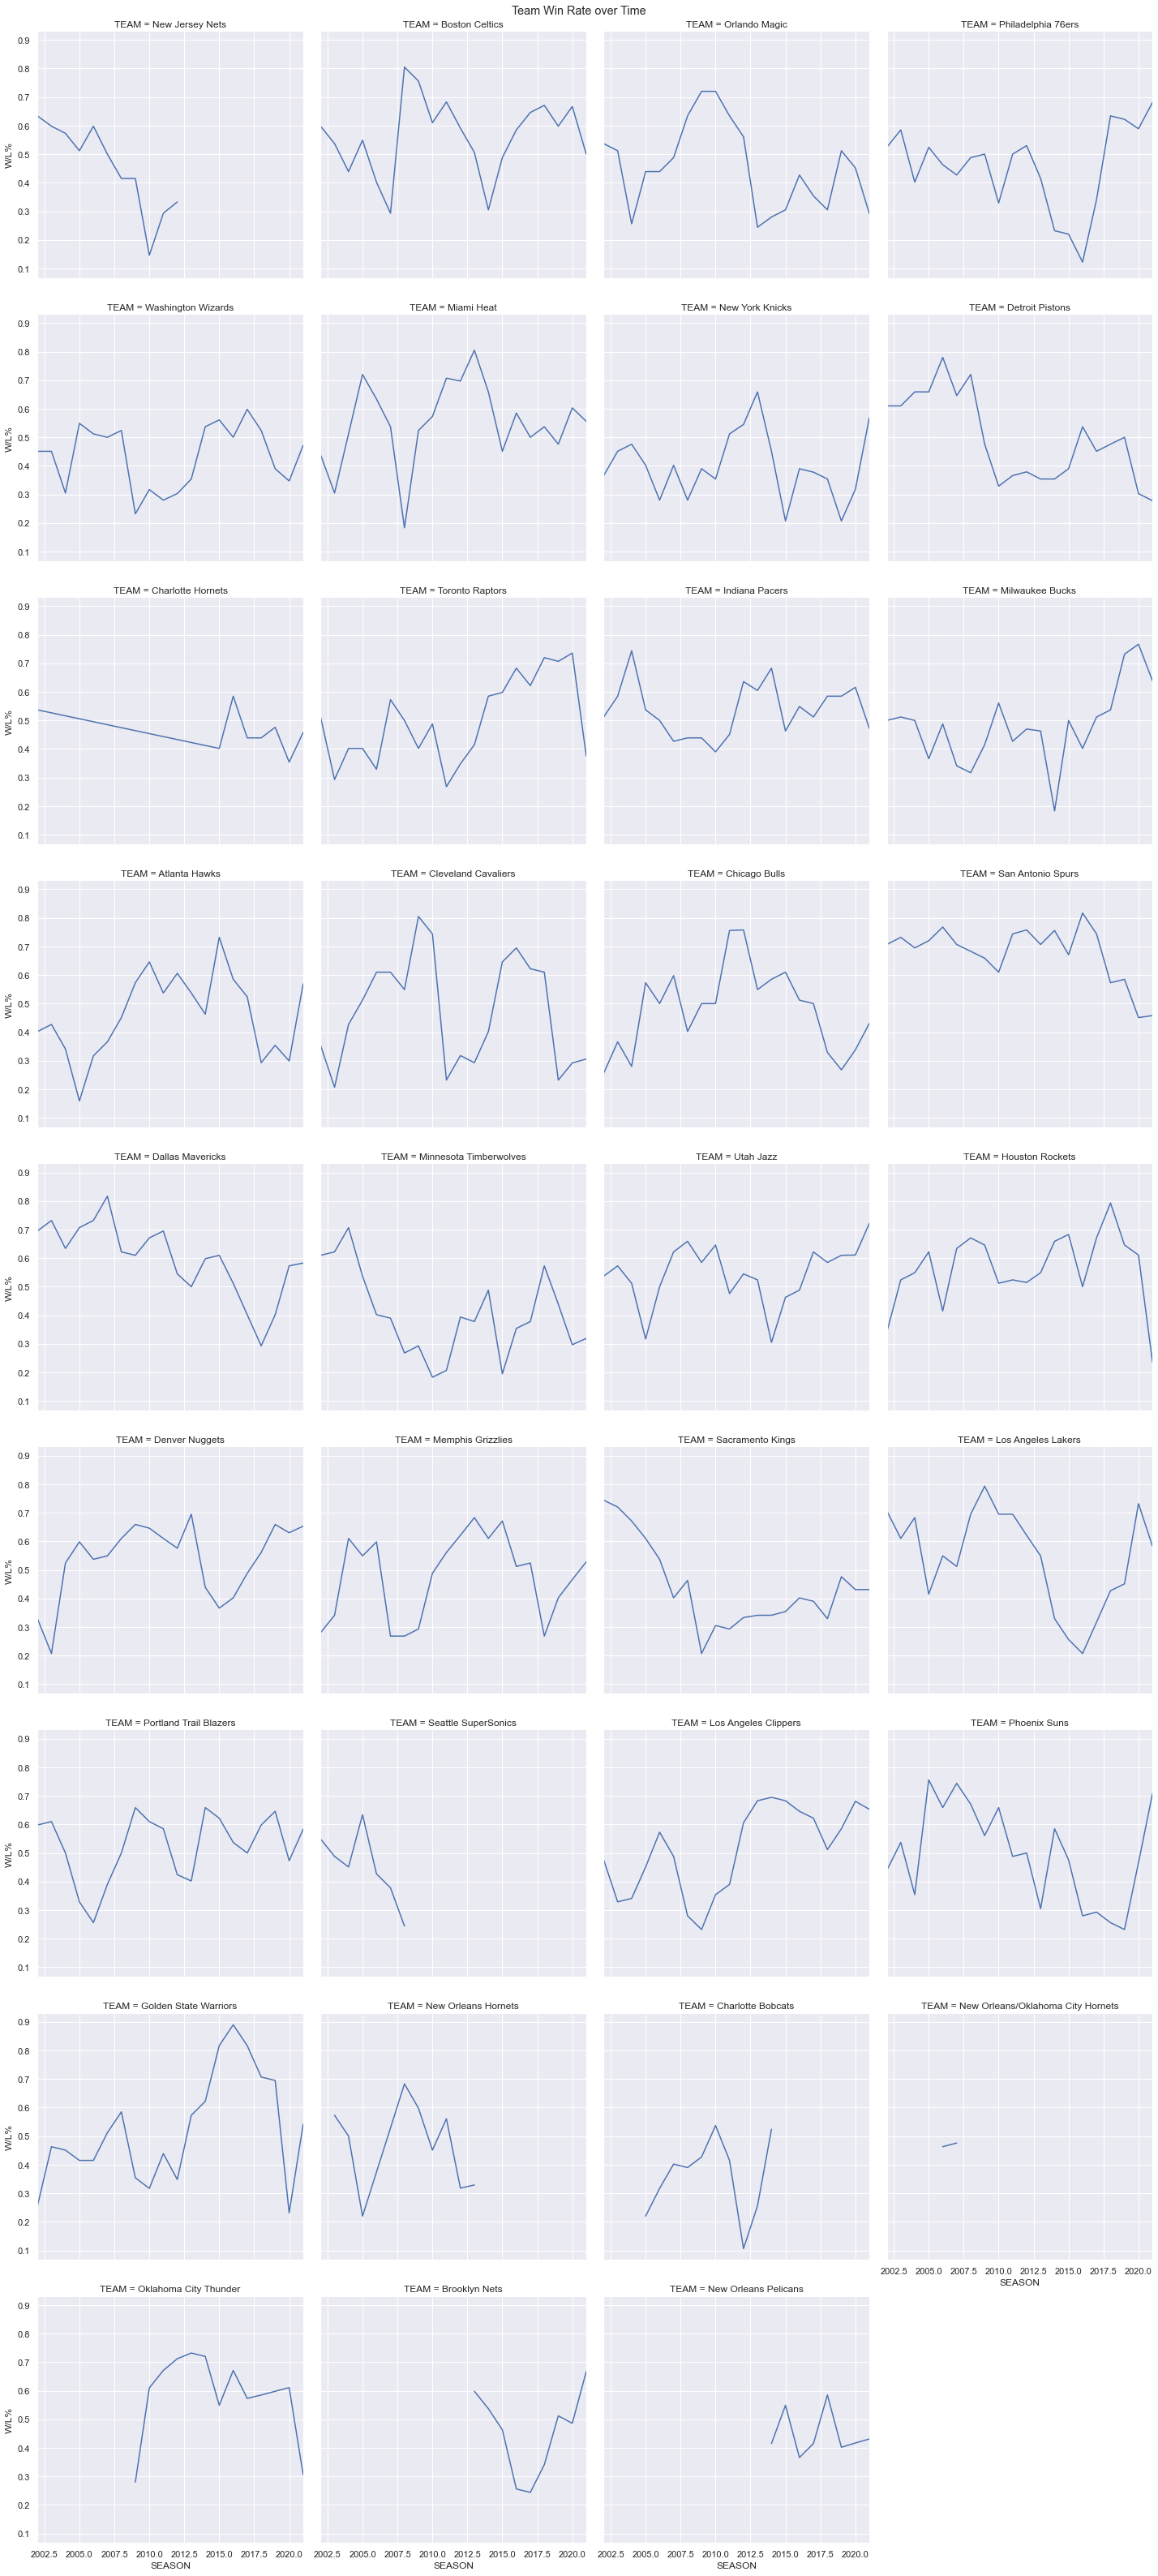

In [194]:
g = sns.FacetGrid(seasons, col='TEAM', col_wrap=4, xlim=(2002, 2021), height=5)

g.map(sns.lineplot, 'SEASON', 'W/L%')
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Team Win Rate over Time')
plt.show()

We can already make some observations from this data. We can see a visual representation of a "tanking" team vs. a slowly declining team. The San Antonio Spurs, for example, were a high win rate team for much of the 2000s and into the 2010s. However, in the late 2010s, their win rate began to decline. This can be attributed to their star players retiring and aging out of the game and their younger players starting to take that place, while failing to live up to previous expectations. What we would expect from a tanking team is a more rapid decline from mediocrity - or even success - to failure. We can see this trajectory in the early 2010s Orlando Magic, as well as the Philadelphia 76ers and Boston Celtics in the mid 2010s. Let's try and visualize this sharp dropoff in win rate. We can start by making a new column that keeps track of the difference in win rate from season to season for each team.

In [195]:
# Need to make a new column for differences between win percentage
team_seasons = seasons.sort_values(['TEAM', 'SEASON'])
team_seasons['W/L DIFF'] = team_seasons.groupby('TEAM')['W/L%'].diff()
team_seasons

,SEASON,TEAM,W,L,W/L%,GB,PW,PL,PS/G,PA/G,W/L DIFF
12,2002,Atlanta Hawks,33,49,0.402,17.0,29,53,94.0,98.3,NaN
40,2003,Atlanta Hawks,35,47,0.427,15.0,31,51,94.1,97.6,0.025
71,2004,Atlanta Hawks,28,54,0.341,33.0,28,54,92.8,97.5,-0.086
101,2005,Atlanta Hawks,13,69,0.159,46.0,16,66,92.7,102.5,-0.182
131,2006,Atlanta Hawks,26,56,0.317,26.0,28,54,97.2,102.0,0.158
...,...,...,...,...,...,...,...,...,...,...,...
450,2017,Washington Wizards,49,33,0.598,4.0,46,36,109.2,107.4,0.098
484,2018,Washington Wizards,43,39,0.524,16.0,43,39,106.6,106.0,-0.074
517,2019,Washington Wizards,32,50,0.390,28.0,34,48,114.0,116.9,-0.134
546,2020,Washington Wizards,25,47,0.347,30.5,26,46,114.4,119.1,-0.043


Then, we can plot these win rate differences in a similar facet grid to our win percentage graph.

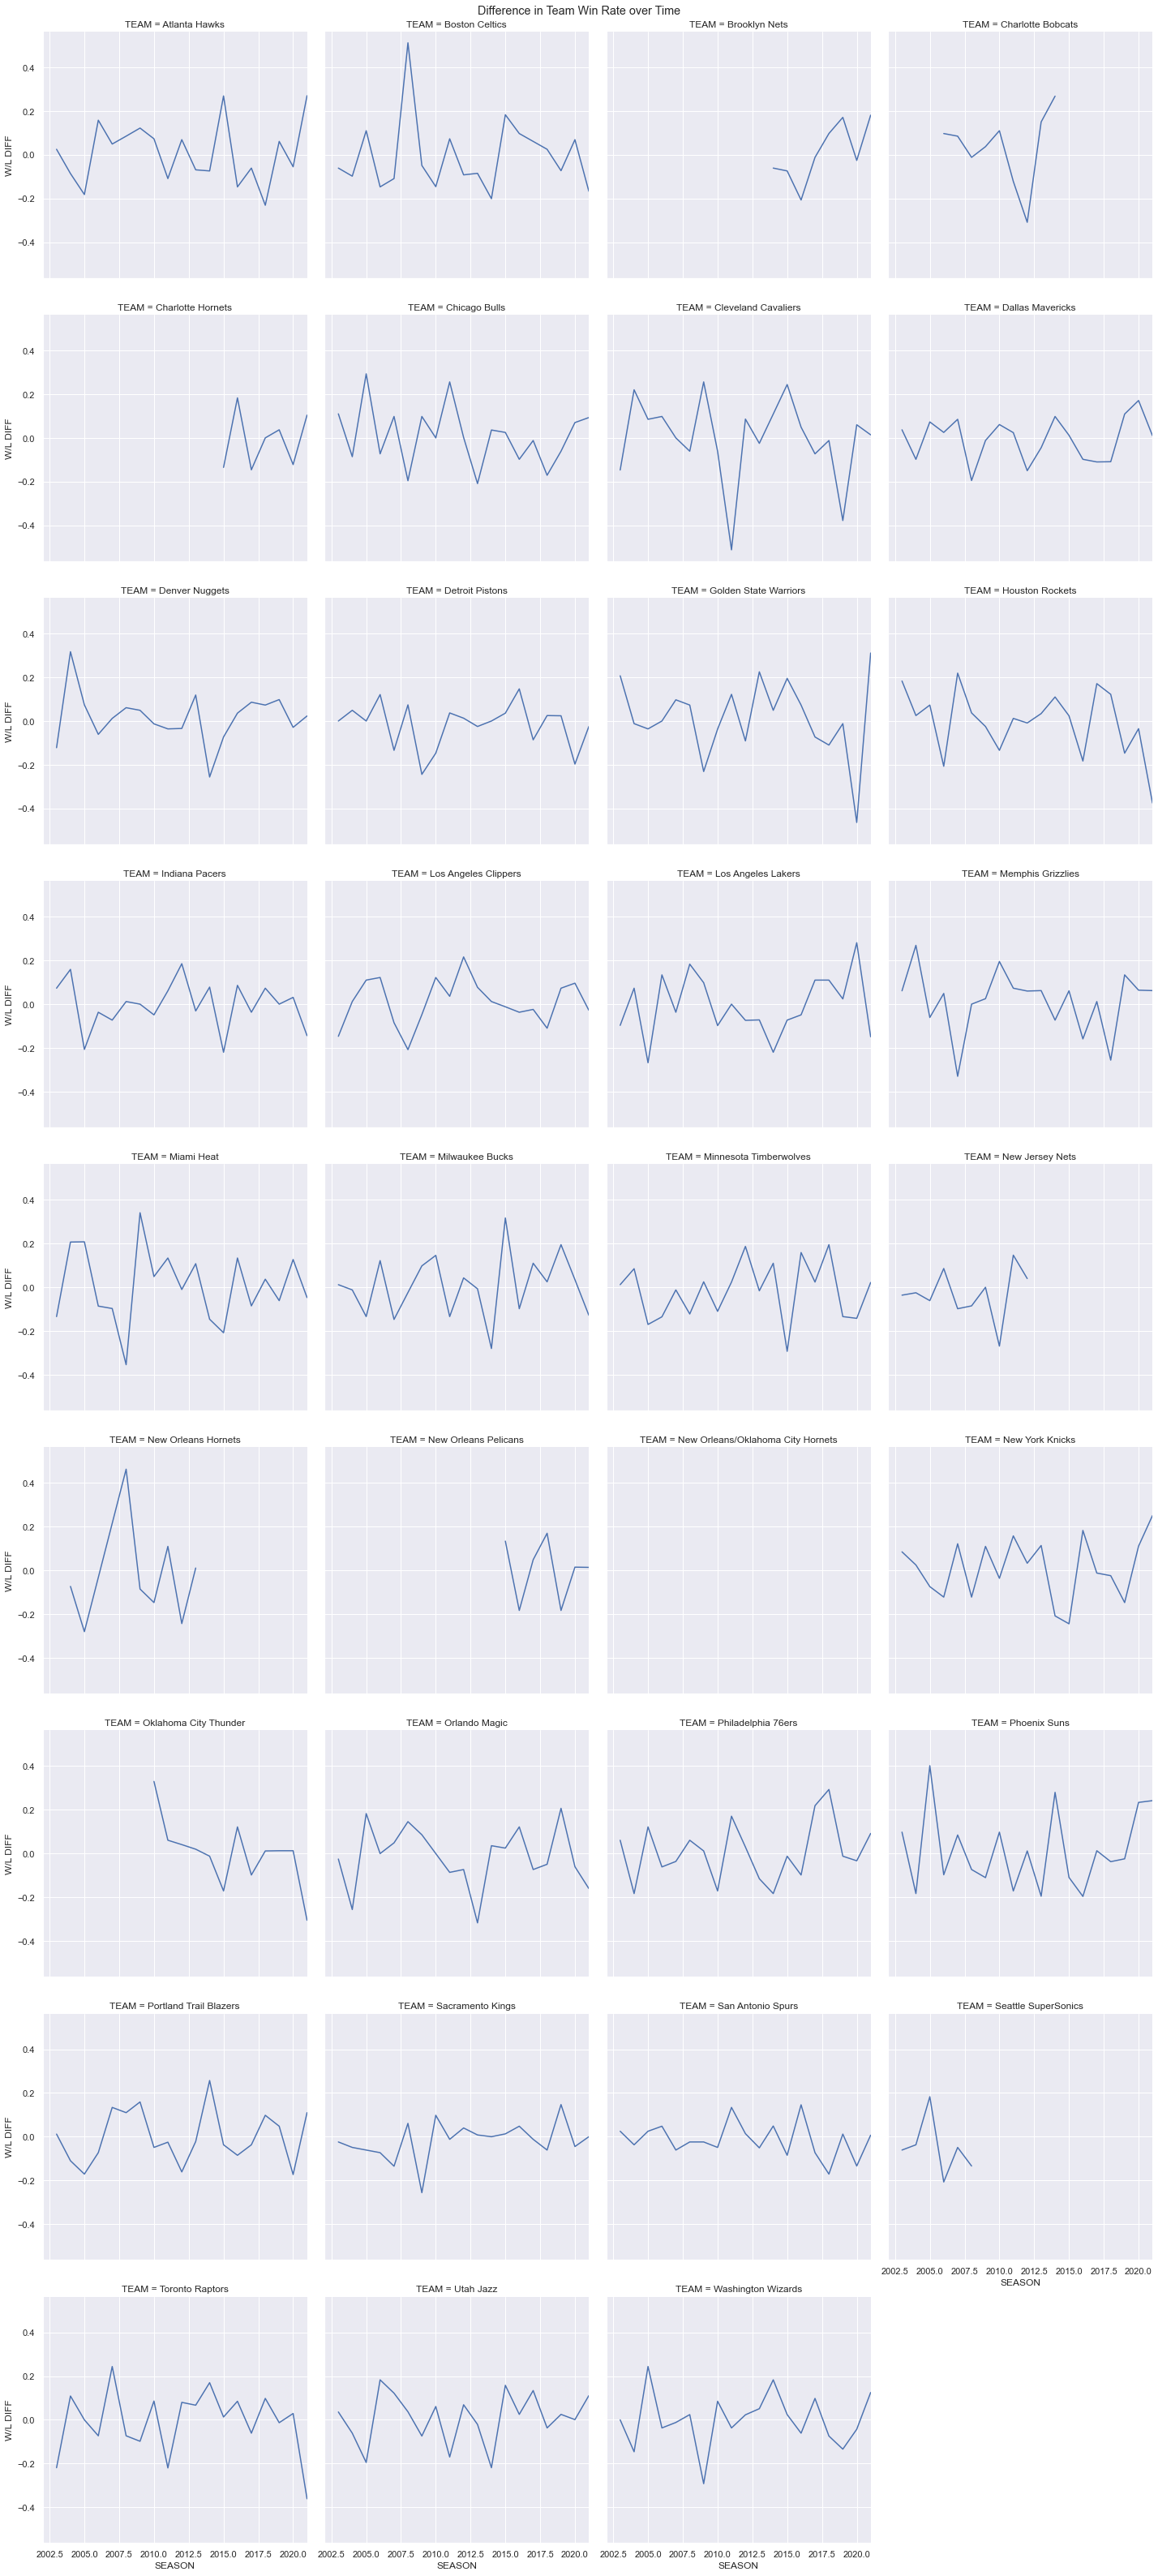

In [196]:
g = sns.FacetGrid(team_seasons, col='TEAM', col_wrap=4, xlim=(2002, 2021), height=5)

g.map(sns.lineplot, 'SEASON', 'W/L DIFF')
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Difference in Team Win Rate over Time')
plt.show()

We can more clearly see which teams had sharp drops in win rate here, as well as when these drops occurred. Those sharp negative drops can provide some indication of when a team entered their tanking period. Some interesting ones to note are the Toronto Raptors following their title in 2019 and the Houston Rockets massive decline in the late 2010s following the exit of star players James Harden and Chris Paul. Let's sort these teams to see which teams and seasons had the biggest win rate drop.

In [197]:
team_seasons_sorted = team_seasons.sort_values(['W/L DIFF'])
team_seasons_sorted.head(20)

,SEASON,TEAM,W,L,W/L%,GB,PW,PL,PS/G,PA/G,W/L DIFF
276,2011,Cleveland Cavaliers,19,63,0.232,43.0,18,64,95.5,104.5,-0.512
566,2020,Golden State Warriors,15,50,0.231,34.0,16,49,106.3,115.0,-0.464
520,2019,Cleveland Cavaliers,19,63,0.232,41.0,19,63,104.5,114.1,-0.378
596,2021,Houston Rockets,17,55,0.236,35.0,20,52,108.8,116.7,-0.375
578,2021,Toronto Raptors,27,45,0.375,22.0,35,37,111.3,111.7,-0.361
191,2008,Miami Heat,15,67,0.183,37.0,18,64,91.4,100.0,-0.354
176,2007,Memphis Grizzlies,22,60,0.268,45.0,27,55,101.6,106.7,-0.330
341,2013,Orlando Magic,20,62,0.244,46.0,22,60,94.1,101.1,-0.317
311,2012,Charlotte Bobcats,7,59,0.106,39.0,7,59,87.0,100.9,-0.309
595,2021,Oklahoma City Thunder,22,50,0.306,30.0,15,57,105.0,115.6,-0.305


## Do Tankers Succeed?

This list of the top 20 win drop offs is not necessarily a perfect indicator of tanking for many of the reasons mentioned above (older players leaving, teams changing, etc). However, we can use this as a proxy for some further analysis. Do these teams have success following such monsterous dropoffs? Let's take a look at how long it takes each of these teams to have a positive win loss difference.

Let's take this list of 20 possible tanking teams and plot their win loss difference after their dropoff year. We can use a loop of seaborn lineplots.

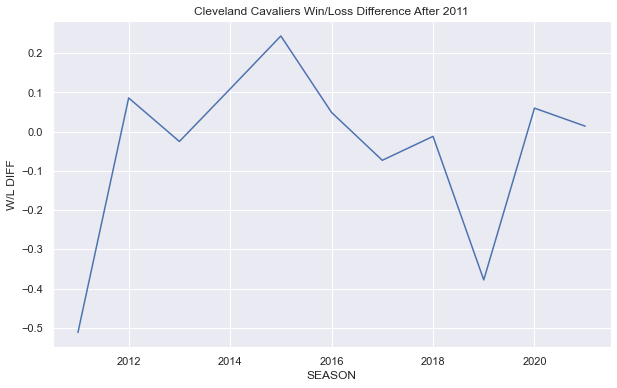

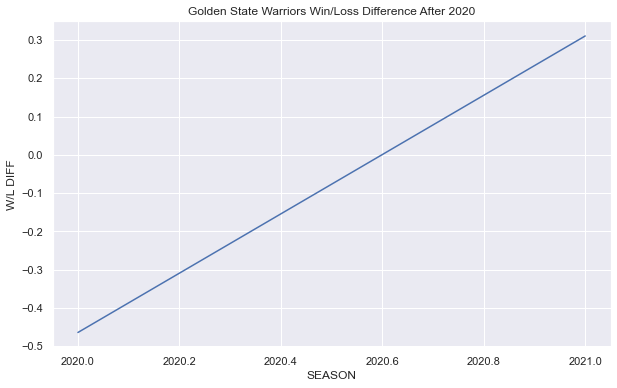

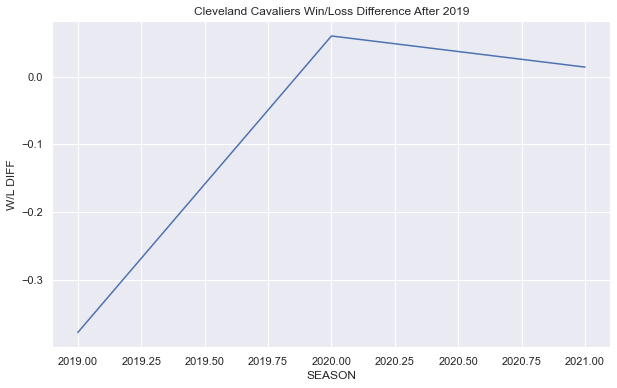

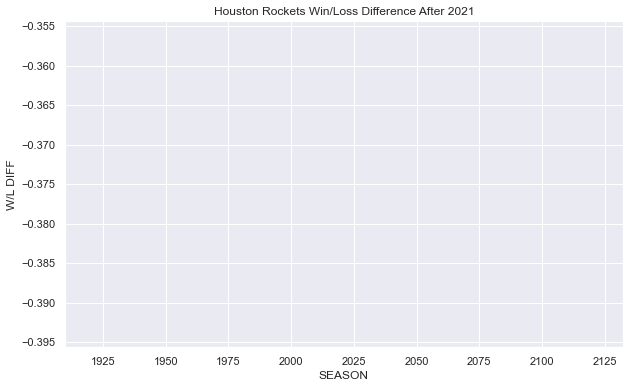

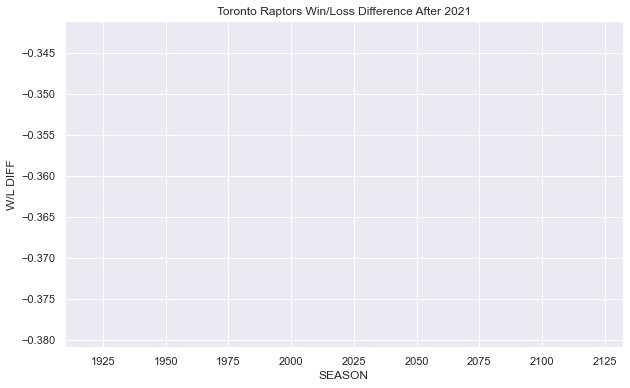

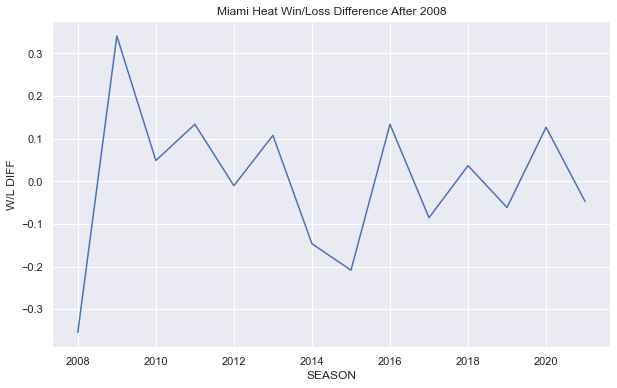

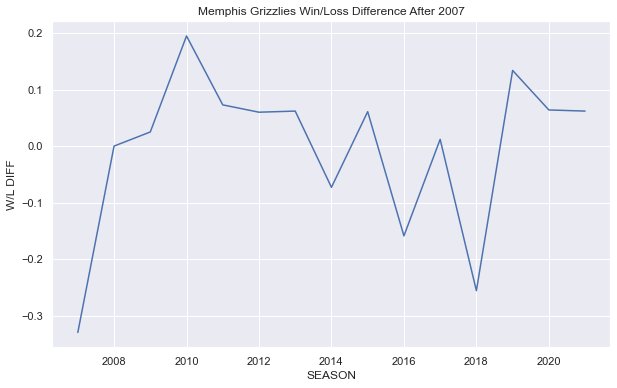

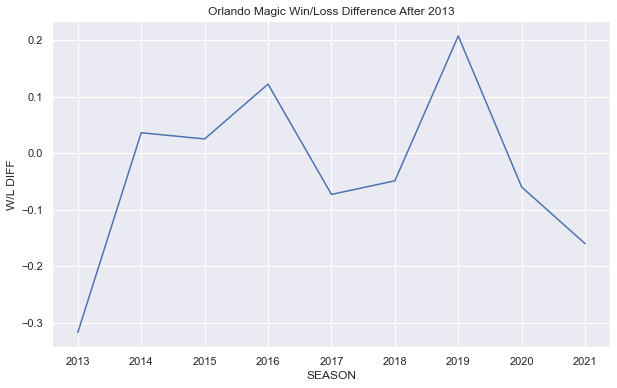

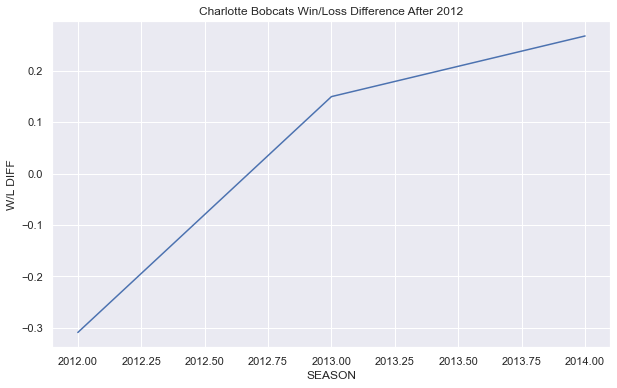

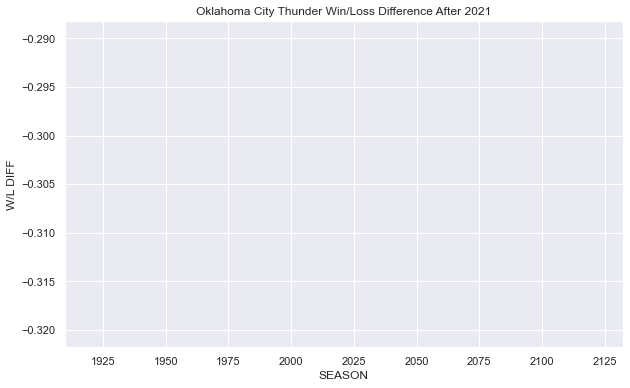

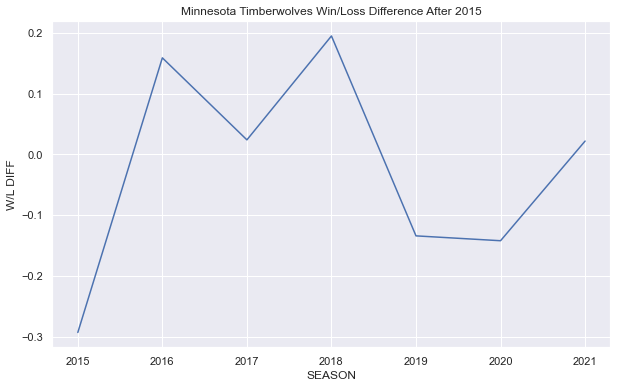

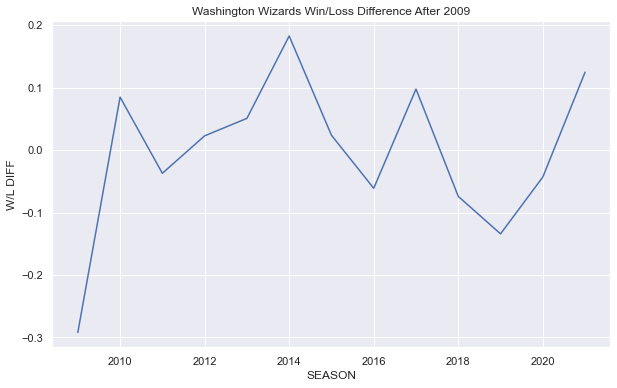

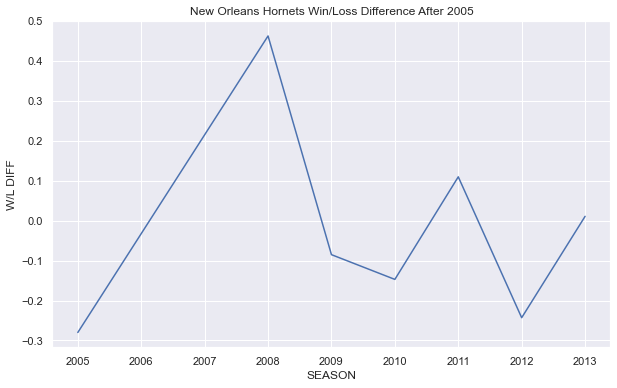

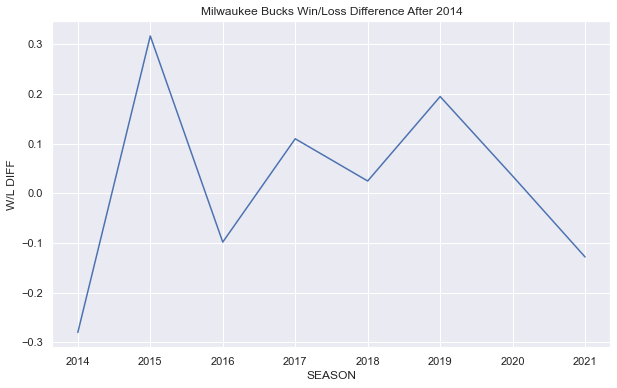

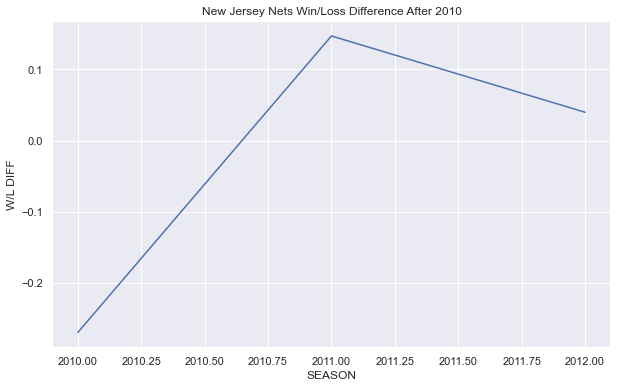

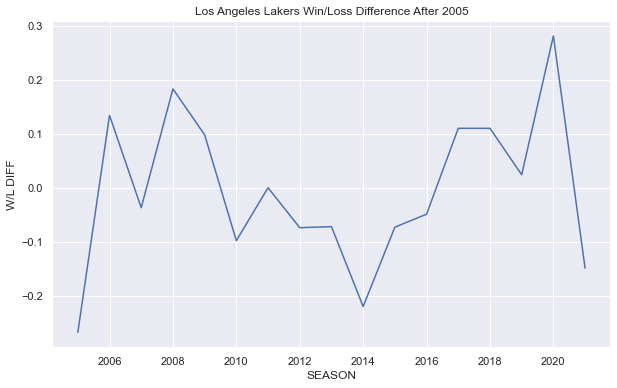

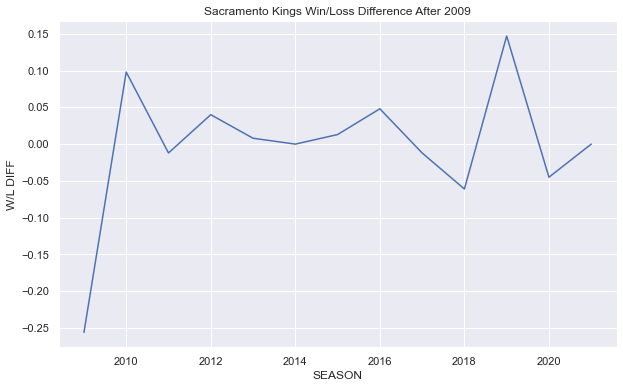

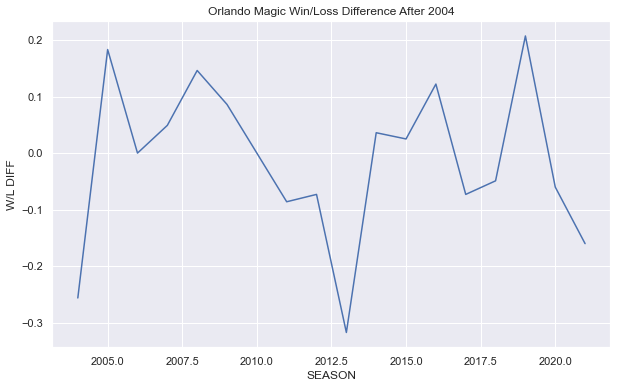

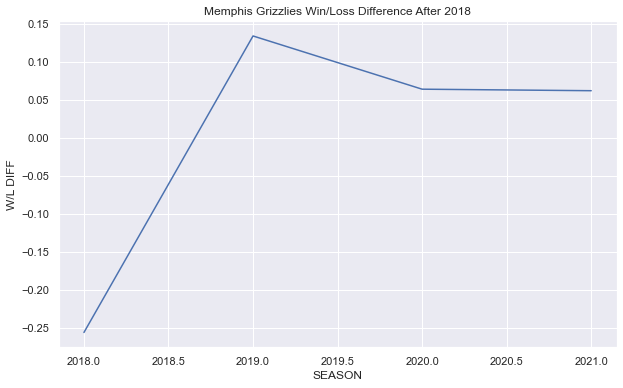

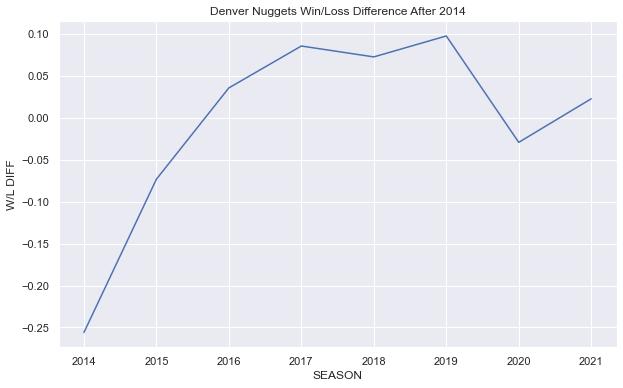

In [198]:
# Plot the win rates following the tanking seasons of each tanking team
# First lets get that top 20 list of seasons and teams.
tankers20 = team_seasons_sorted.head(20)

# For each row here, look at rows in the sorted dataframe queried by team after the season
sns.set(rc = {'figure.figsize':(10,6)})
i = 0
for index, row in tankers20.iterrows():
    query = 'TEAM == "' + row['TEAM'] + '" & SEASON >= ' + str(row['SEASON'])
    df = team_seasons.query(query)

    # Make plot here
    plt.figure(i)
    sns.lineplot(data=df, x='SEASON', y='W/L DIFF').set(title=row['TEAM'] + ' Win/Loss Difference After ' + str(row['SEASON']))
    i += 1

It seems that for each of these tanking teams, the bleeding did eventually stop. In some cases, such as the Orlando Magic after 2004, the improvement was rapid. They were able to have a positive improvement in win loss difference after just one season. Some teams, such as the Denver Nuggets after 2014 kept dropping in win rate for a couple of years, but began improving soon after. These sharp dropoffs in win rate do not seem to last forever. Some of the tanking candidates in our list have only just entered their period of sharp decline, however, so we do not have enough data on them to come to any conclusion. Keeping track of these team's progress (the Houston Rockets and the Toronto Raptors) over the following season might yield more conclusive results in the future.

## Conclusions

Classifying a team as tanking as opposed to restructuring or facing rapid decline is a tricky problem. In this case, we took a look at the teams that most quickly dropped off in season performance. This provided a simplified view of what a tanking team could look like, and we were able to come to the preliminary conclusion that these rapid dropoffs do not persist over a long period of time. In every case we examined, the team returned to improvement the very next season, however slow. However, there are a number of variables left to explore. The way in which teams enter a tanking process varies. Are they benching their star players, or trading them away? Do their game plans and rotations suddenly change when they have a lead in a game? Further analysis with datasets that include player trades and even play by play calls can bring more insight to these questions. Additionally, there is the question of the "slow tank" process, as can be seen in teams like [the mid-2010s Philadelphia 76ers](https://bleacherreport.com/articles/2729018-the-definitive-history-of-trust-the-process). How can these types of long rebuilds be identified, and do they lead to positive outcomes as well? There are a wealth more questions to explore within the topic of NBA tanking. This early exploration has opened the field for many of these avenues for future analysis.